### - Sobhan Moradian Daghigh
#### - 5/7/2022
#### - DIP - HW02 - Q4

In [1]:
import numpy as np
from PIL import Image
import cv2
from IPython.display import display
from matplotlib import pyplot as plt
import glob

### Part A.

In [93]:
def load_datas(folder_name):
    images = glob.glob('{}*.png'.format(folder_name))
    datas = []
    names = []
    for image in images:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (300, 300)) # For speeding up!
        datas.append(img)      
        names.append(image.split('\\')[1][:-4])
    return datas, names

In [94]:
images, names = load_datas('./inputs/P4/')
names

['putin', 'putin_mask', 'zelensky', 'zelensky_mask']

In [46]:
def get_neighbours(pixel, window):
    neighbours = [] 
    margin = window // 2
    for i in range(pixel[0] - margin, pixel[0] + margin + 1):
        for j in range(pixel[1] - margin, pixel[1] + margin + 1):
            neighbours.append((i, j))
    return neighbours

In [47]:
def zero_paddig(img, margin):
    pad = np.zeros(np.add(img.shape, (2 * margin, 2 * margin, 0)))
    pad[margin:-margin, margin:-margin] = img
    return pad

In [48]:
def bilateral_filter(img, window, sigma_r, sigma_d):
    margin = window // 2
    pad = zero_paddig(img, margin)
    filterd = np.zeros(img.shape).astype(np.uint8)
    
    for i in range(margin, pad.shape[0] - margin):
        for j in range(margin, pad.shape[1] - margin):
            w_sum = 0
            pixel_sum = 0
            neighbours = get_neighbours((i, j), window=window)
            for neighbour in neighbours:
                w = np.exp(np.subtract(- np.divide(np.add(np.power(i - neighbour[0], 2), np.power(j - neighbour[1], 2)), 2 * np.power(sigma_d, 2)), np.divide(np.power(pad[i, j] - pad[neighbour], 2), 2 * np.power(sigma_r, 2))))
                w_sum += w
                pixel_sum += np.multiply(pad[neighbour], w)
                
            filterd[i - margin, j - margin] = np.divide(pixel_sum, w_sum)
    
    return filterd

In [49]:
def get_masked(img, mask):
    res = cv2.bitwise_and(img, mask)
    return res

### Part B.

In [95]:
sigma_d = [10, 20, 30, 40]
sigma_r = [20, 30, 40, 50]
windows = [3, 5, 7, 9]

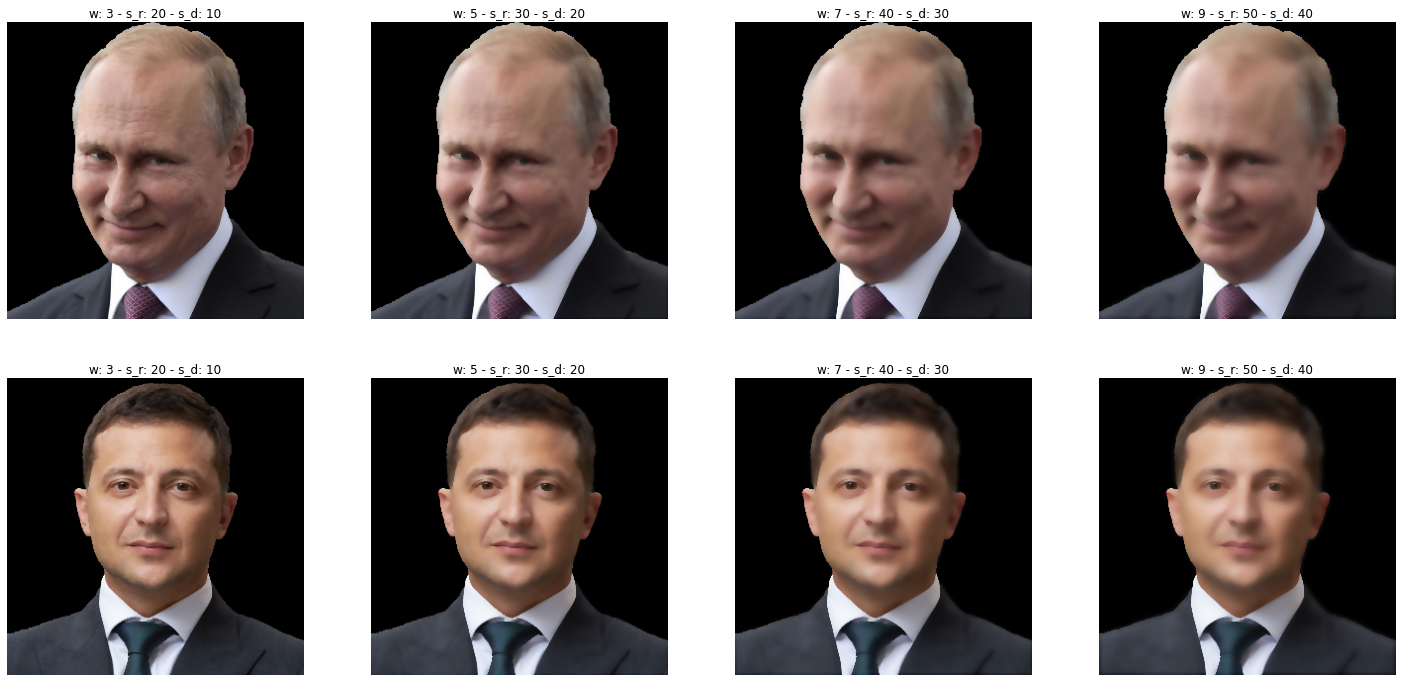

In [96]:
fig, axes = plt.subplots(2, 4, figsize=(25, 12))
filterds = []
for i, idx in enumerate(range(0, len(images), 2)):
    img = get_masked(images[idx], images[idx + 1])
    for j, (sig_r, sig_d, wind) in enumerate(zip(sigma_r, sigma_d, windows)):
        filterd = bilateral_filter(img, window=wind, sigma_r=sig_r, sigma_d=sig_d)
        filterds.append(filterd)
        axes[i, j].imshow(filterd)
        axes[i, j].set_title('w: {} - s_r: {} - s_d: {}'.format(windows[j], sigma_r[j], sigma_d[j]))
        axes[i, j].axis('off')
plt.show()

### Part C.

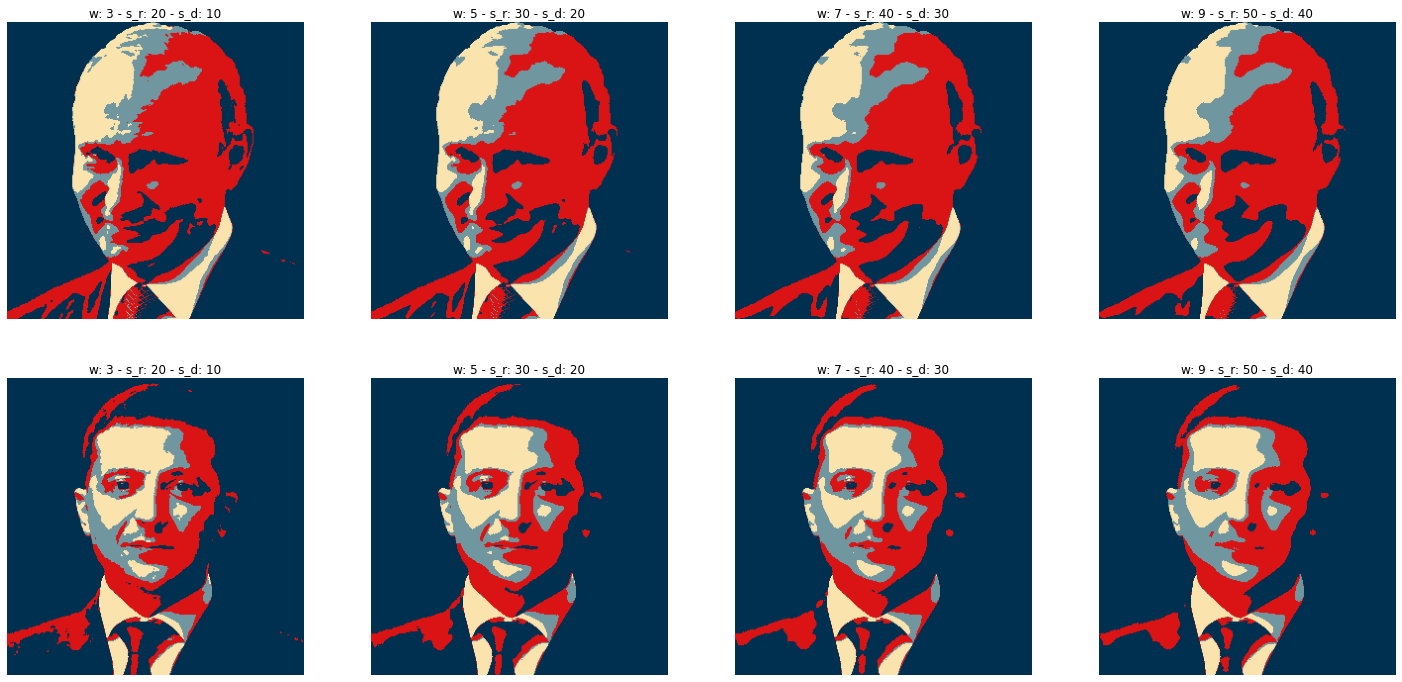

In [99]:
fig, axes = plt.subplots(2, 4, figsize=(25, 12))
filterd_color = []
for k, (flt, ax) in enumerate(zip(filterds, axes.reshape(-1))):
    img = cv2.cvtColor(flt, cv2.COLOR_RGB2GRAY)
    color_img = np.zeros((img.shape[0], img.shape[0], 3)).astype(np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] < 70:
                color_img[i, j] = [0, 48, 80]
            elif img[i, j] < 140:
                color_img[i, j] = [218, 20, 21]
            elif img[i, j] < 170:
                color_img[i, j] = [112, 150, 160]
            elif img[i, j] <= 255:
                color_img[i, j] = [250, 227, 173]
                
    filterd_color.append(color_img)
    ax.imshow(color_img)
    ax.set_title('w: {} - s_r: {} - s_d: {}'.format(windows[np.mod(k, 4)], sigma_r[np.mod(k, 4)], sigma_d[np.mod(k, 4)]))
    ax.axis('off')
plt.show()

### Part D.

In [120]:
def color_bg(img, mask):
    blank = np.zeros(img.shape).astype(np.uint8)
    blank[:, :img.shape[1] // 2] = [112, 150, 160]
    blank[:, img.shape[1] // 2:] = [218, 20, 21]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if all(mask[i, j] != [0, 0, 0]):
                blank[i, j] = img[i, j]
    return blank

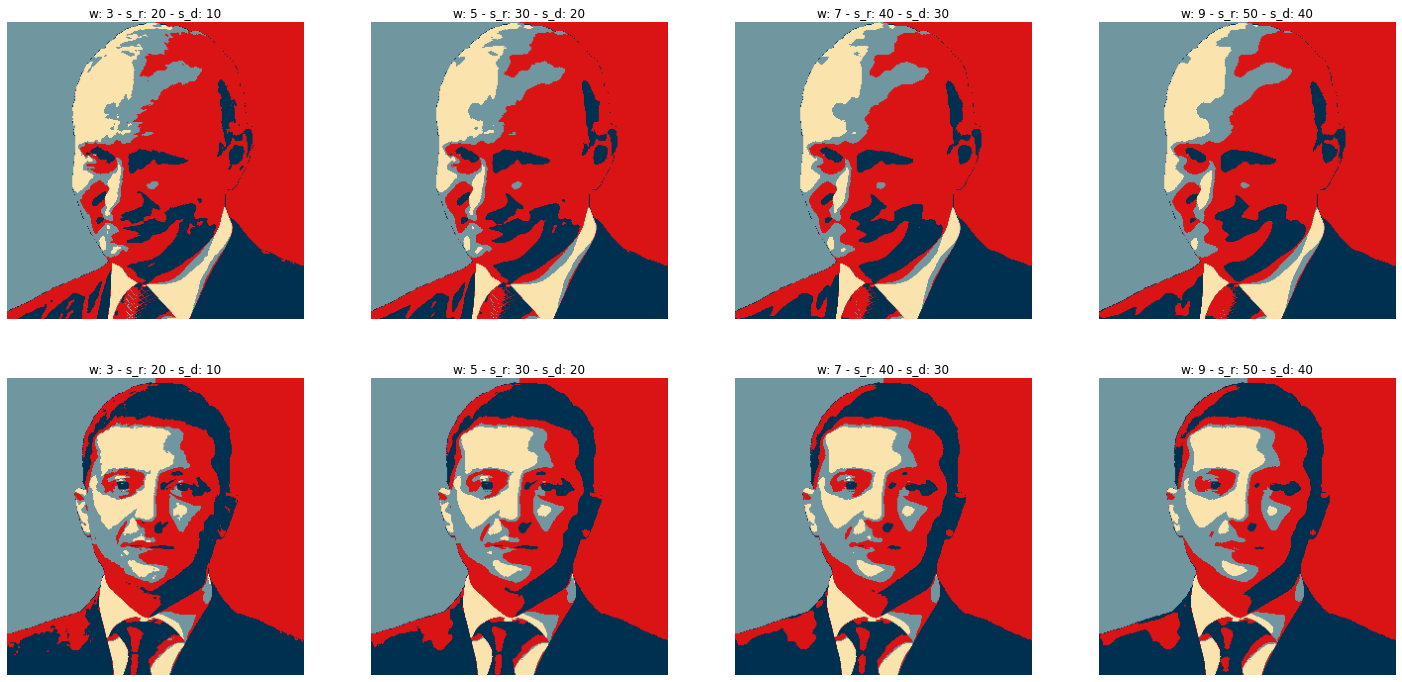

In [121]:
fig, axes = plt.subplots(2, 4, figsize=(25, 12))

for k, (img, ax) in enumerate(zip(filterd_color, axes.reshape(-1))):
    final = color_bg(img, images[int(np.floor(k / 4)) * 2 + 1]) # np.floor(k / 4) * 2 + 1 : Try to find ind 1 and 3 for masks :)
    ax.imshow(final)
    ax.set_title('w: {} - s_r: {} - s_d: {}'.format(windows[np.mod(k, 4)], sigma_r[np.mod(k, 4)], sigma_d[np.mod(k, 4)]))
    ax.axis('off')
plt.show()

### Finito